# Data Challenge

### Table of Contents

1. [Part 1](#:Part1)
   
   1.2 [Libraries](#Libraries)
   
   1.3 [Data import and merging](#Data-import-and-merging)
   
   1.4 [Output File](#Output-File)
   
   

2. [Part 2](#Part-2)
   
   2.1 [Exploratory Data Analysis](#Exploratory-Data-Analysis)
      
   2.2 [Graph of Price vs Region ](#Graph-of-Price-vs-Region)
      
   2.3 [Graph: Mean Price Vs Banner](#Graph:-Mean-Price-Vs-Banner)
   
   2.4 [Verifying the anomalies](#Verifying-the-anomalies)
     
      - [Anomaly 1: Kansas WholeFood Average Price](#Anomaly-1:-Kansas-WholeFood-Average-Price)
      - [Anomaly 2: Three Auditors in Northern California](#Anomaly-2:-Three-Auditors-in-Northern-California)
   
   2.6 [ONE WAY ANOVA: Kruskal Wallis Test](#ONE-WAY-ANOVA:-Kruskal-Wallis-Test)
      - [Checking Normality for Price](#Checking-Normality-for-Price)
      
   2.7 [Findings](#Findings)
   
   2.8 [Conclusions](#Conclusions)
   
   2.9 [References](#References)

### Part 1

#### Libraries

In [1]:
#import required libraries
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
from scipy import stats
from scipy.stats import norm, skew
from scipy import stats
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('classic')
plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn')

#### Data import and merging

In [2]:
#import json file
stores = pd.read_json("stores.json")
stores.head()

,Banner,Region,Store ID
0,Walmart,Northern California,66999
1,Trader Joes,Northern California,4698
2,Safeway,Northern California,39482
3,Whole Foods,Northern California,34957
4,Walmart,New York,12837


In [3]:
#import price data
price = pd.read_csv("prices.csv")
price.head()

,Auditor ID,Date,Price,Store ID,UPC
0,234,10/18/2017,24.95,66999,268588472
1,234,10/27/2017,49.71,66999,475245085
2,234,10/20/2017,25.75,66999,126967843
3,234,10/23/2017,18.81,66999,708930835
4,234,10/23/2017,33.32,66999,325885139


In [4]:
#import auditor data
auditor = pd.read_csv("auditors.csv")
auditor.head()

,Auditor ID,First,Last,Region
0,234,Sue,Smith,Northern California
1,536,Bob,Smith,Northern California
2,98,Jack,Smith,New York
3,203,Jill,Smith,New York
4,304,Jerry,Johnson,Texas


In [5]:
#merge stores and prices data
merged_stores_price = pd.merge(stores, price, on= "Store ID")
merged_stores_price.head()

,Banner,Region,Store ID,Auditor ID,Date,Price,UPC
0,Walmart,Northern California,66999,234,10/18/2017,24.95,268588472
1,Walmart,Northern California,66999,234,10/27/2017,49.71,475245085
2,Walmart,Northern California,66999,234,10/20/2017,25.75,126967843
3,Walmart,Northern California,66999,234,10/23/2017,18.81,708930835
4,Walmart,Northern California,66999,234,10/23/2017,33.32,325885139


In [6]:
#change datatype of Date column
merged_stores_price['Date']= merged_stores_price['Date'].astype('datetime64[ns]')

In [7]:
# merge auditor data with merged_stores_price
df_merged= pd.merge(merged_stores_price, auditor, on="Auditor ID")
df_merged.head()

,Banner,Region_x,Store ID,Auditor ID,Date,Price,UPC,First,Last,Region_y
0,Walmart,Northern California,66999,234,2017-10-18,24.95,268588472,Sue,Smith,Northern California
1,Walmart,Northern California,66999,234,2017-10-27,49.71,475245085,Sue,Smith,Northern California
2,Walmart,Northern California,66999,234,2017-10-20,25.75,126967843,Sue,Smith,Northern California
3,Walmart,Northern California,66999,234,2017-10-23,18.81,708930835,Sue,Smith,Northern California
4,Walmart,Northern California,66999,234,2017-10-23,33.32,325885139,Sue,Smith,Northern California


In [8]:
#drop Region_y column and rename Region_x to Region
df_merged = df_merged.drop(['Region_y'], axis=1)
df_merged = df_merged.rename(columns= {"Region_x": "Region"})
df_merged.head()

,Banner,Region,Store ID,Auditor ID,Date,Price,UPC,First,Last
0,Walmart,Northern California,66999,234,2017-10-18,24.95,268588472,Sue,Smith
1,Walmart,Northern California,66999,234,2017-10-27,49.71,475245085,Sue,Smith
2,Walmart,Northern California,66999,234,2017-10-20,25.75,126967843,Sue,Smith
3,Walmart,Northern California,66999,234,2017-10-23,18.81,708930835,Sue,Smith
4,Walmart,Northern California,66999,234,2017-10-23,33.32,325885139,Sue,Smith


In [9]:
# create the cross table
df = pd.crosstab([df_merged.Banner, df_merged.UPC], df_merged.Region,values=df_merged.Price, aggfunc='mean',colnames=['index'])
# reset the index
df_merged= df_merged.reset_index()
df_final = df.reset_index()
# change the col order 
columnsTitles = ['Banner', 'UPC', 'Northern California','New York','Kansas','Texas']

In [10]:
# reindex the data
df_final = df_final.reindex(columns=columnsTitles)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4931 entries, 0 to 4930
Data columns (total 6 columns):
Banner                 4931 non-null object
UPC                    4931 non-null int64
Northern California    1634 non-null float64
New York               3025 non-null float64
Kansas                 3087 non-null float64
Texas                  3765 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 231.2+ KB


In [11]:
# sort the data UPC number in ascending order
df_final = df_final.sort_values(by=['UPC'])
df_final.head(15)

index,Banner,UPC,Northern California,New York,Kansas,Texas
0,Safeway,11873171,6.09,NaN,NaN,5.19
1953,Walmart,11873171,5.53,NaN,NaN,4.75
3934,Whole Foods,11873171,NaN,5.69,1.99,5.49
977,Trader Joes,11873171,NaN,NaN,NaN,4.99
2938,Wegmans,11873171,NaN,5.19,NaN,5.09
1954,Walmart,15052612,57.13,50.75,NaN,NaN
1,Safeway,15052612,NaN,NaN,53.99,54.49
978,Trader Joes,15052612,60.19,NaN,NaN,NaN
3935,Whole Foods,15052612,NaN,59.49,1.99,57.79
2939,Wegmans,15052612,NaN,54.49,52.39,52.89


#### Output File

In [12]:
#printing the generatred output to .csv file
df_final.to_csv("output.csv", index=False)

### Part 2

#### Exploratory Data Analysis

In [13]:
df_merged= df_merged.drop("index", axis= 1)
df_merged.head()

,Banner,Region,Store ID,Auditor ID,Date,Price,UPC,First,Last
0,Walmart,Northern California,66999,234,2017-10-18,24.95,268588472,Sue,Smith
1,Walmart,Northern California,66999,234,2017-10-27,49.71,475245085,Sue,Smith
2,Walmart,Northern California,66999,234,2017-10-20,25.75,126967843,Sue,Smith
3,Walmart,Northern California,66999,234,2017-10-23,18.81,708930835,Sue,Smith
4,Walmart,Northern California,66999,234,2017-10-23,33.32,325885139,Sue,Smith


In [14]:
df_merged["Date"]= df_merged["Date"].astype("datetime64[ns]")

In [15]:
#Dropped three columns namely Store ID, First, Last. 
df_merged= df_merged.drop(["Store ID", "First", "Last"], axis= 1)

In [16]:
df_merged.head(10)

,Banner,Region,Auditor ID,Date,Price,UPC
0,Walmart,Northern California,234,2017-10-18,24.95,268588472
1,Walmart,Northern California,234,2017-10-27,49.71,475245085
2,Walmart,Northern California,234,2017-10-20,25.75,126967843
3,Walmart,Northern California,234,2017-10-23,18.81,708930835
4,Walmart,Northern California,234,2017-10-23,33.32,325885139
5,Walmart,Northern California,234,2017-10-16,40.43,509419735
6,Walmart,Northern California,234,2017-10-22,35.10,736362595
7,Walmart,Northern California,234,2017-10-21,33.65,652377244
8,Walmart,Northern California,234,2017-10-16,22.30,277394644
9,Walmart,Northern California,234,2017-10-20,12.32,996849471


#### Graph: Mean Price Vs Banner

In [17]:
#Grouping the data by Banner name and taking mean of the proce column
banner_groupby = df_merged.groupby(['Banner']).mean().drop(columns= ['UPC', 'Auditor ID'])
banner_groupby

,Price
Banner,
Safeway,31.379302
Trader Joes,30.504743
Walmart,28.877602
Wegmans,30.465411
Whole Foods,24.111734


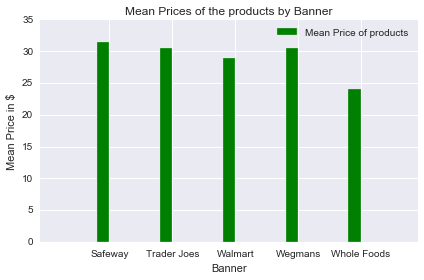

In [18]:
#Plotting the means of the prices for Banner names

n_groups = 5

mean_price = banner_groupby['Price']
fig, ax = plt.subplots()
bar_width = 0.2
index = np.arange(n_groups)
error_config = {'ecolor': '0.3'}
rects1 = ax.bar(index, mean_price, bar_width, color='g',
                label='Mean Price of products')

ax.set_xlabel('Banner')
ax.set_ylabel('Mean Price in $')
ax.set_title('Mean Prices of the products by Banner')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Safeway', 'Trader Joes', 'Walmart', 'Wegmans', 'Whole Foods'))
ax.legend()

fig.tight_layout()
 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

plt.show()

From the above plot, we can infer that the lowest mean price is for Whole Foods Supermarket.

In [19]:
region_groupby = df_merged.groupby(['Region']).mean()
region_groupby = region_groupby.drop(columns=['UPC', 'Auditor ID'])
region_groupby

,Price
Region,
Kansas,21.390198
New York,30.971137
Northern California,35.437907
Texas,30.084550


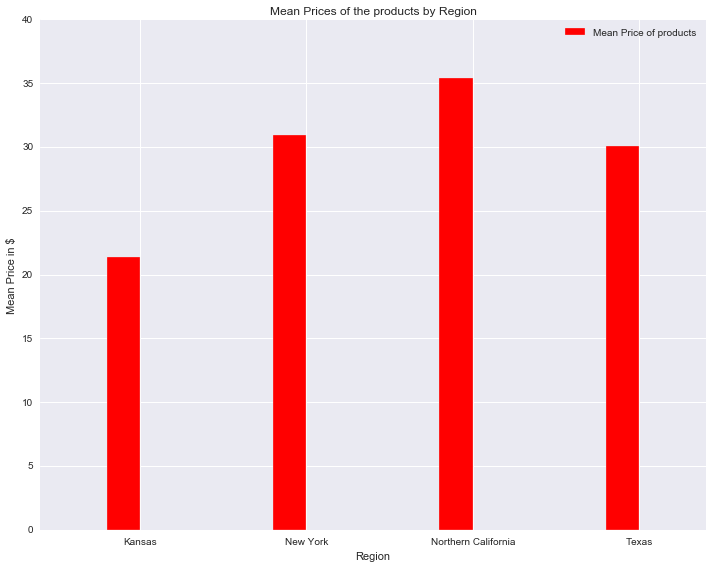

In [20]:
n_groups = 4

mean_price = region_groupby['Price']
fig, ax = plt.subplots()
bar_width = 0.2
index = np.arange(n_groups)
error_config = {'ecolor': '0.3'}
rects1 = ax.bar(index, mean_price, bar_width, color='r',
                label='Mean Price of products')

ax.set_xlabel('Region')
ax.set_ylabel('Mean Price in $')
ax.set_title('Mean Prices of the products by Region')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Kansas', 'New York', 'Northern California', 'Texas'))
ax.legend()

fig.tight_layout()
 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

plt.show()

From the above plot, we can infer that the lowest mean price is for Kansas State. 

In [21]:
region_groupby= df_merged.groupby(by=["Auditor ID", "Region" ,"Banner"]).mean().drop(columns= ["UPC"], axis= 1)
region_groupby= pd.DataFrame(region_groupby)
region_groupby

Price
Auditor ID Region              Banner                
63         Texas               Trader Joes  29.321849
                               Walmart      27.958877
98         New York            Wegmans      30.885284
                               Whole Foods  33.834301
           Northern California Safeway      35.292941
203        New York            Trader Joes  30.521937
                               Walmart      28.427648
234        Northern California Walmart      32.854515
304        Texas               Safeway      30.619833
                               Wegmans      30.121931
                               Whole Foods  32.823461
536        Northern California Trader Joes  34.376035
                               Whole Foods  38.417573
713        Kansas              Wegmans      30.276889
                               Whole Foods   1.989452
1326       Kansas              Safeway      30.694151
                               Trader Joes  29.201024
                               Walmart      27.646769

Text(0.5, 1.0, 'Mean Prices of the products by Banner and Auditor ID')

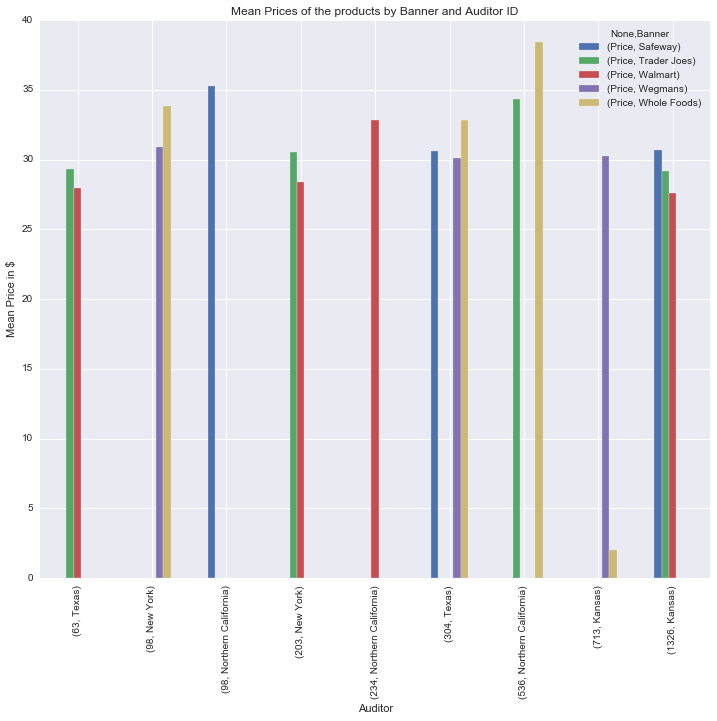

In [22]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

ax = region_groupby.unstack().plot(kind = "bar")
ax.set_xlabel("Auditor")
ax.set_ylabel("Mean Price in $")
ax.set_title('Mean Prices of the products by Banner and Auditor ID')

__From the above plot__ <br>
1. Firstly, we can see from the mean price values that the average price for WholeFoods is \\$24.11. From the above graph, we can infer that Mean Price(\\$) of products of WholeFoods in Kansas is approximately \\$2 as whereas states like New York, Texas have 33.83, 32.82 respectively. This comparison looks questionalble and so we need more granular analysis. 
To mention the Kansas data is collected by Dave Johnsson (Auditor ID: 713).<br>
2. We can also infer that Northern California shows 3 auditors but in Auditor.csv we can see that each Region is assigned to 2 auditors. Auditor ID: 98 is assigned for New York region. However, we can see him as Auditor for Northern California Region. <br>

## Verifying the anomalies

### Anomaly 1: Kansas WholeFood Average Price

In [23]:
df_merged[df_merged["Price"] == 1.99]

,Banner,Region,Auditor ID,Date,Price,UPC
1129,Whole Foods,Northern California,536,2017-10-16,1.99,694468735
1317,Whole Foods,Northern California,536,2017-10-20,1.99,762004012
1321,Whole Foods,Northern California,536,2017-10-25,1.99,770347410
2051,Wegmans,New York,98,2017-10-20,1.99,60168857
2540,Wegmans,New York,98,2017-10-26,1.99,375780233
2746,Whole Foods,New York,98,2017-10-16,1.99,355520088
5674,Safeway,Kansas,1326,2017-10-17,1.99,60168857
6104,Safeway,Kansas,1326,2017-10-28,1.99,375780233
6255,Safeway,Kansas,1326,2017-10-26,1.99,226080317
6324,Safeway,Kansas,1326,2017-10-29,1.99,606513778


From the above table we can clearly see that maximum entries are from Auditor ID: 713 in Kansas are \\$1.99. Let us consider one of the UPC `228431403` and check the price for a different banner in Kansas

In [24]:
# Sample UPC number of Auditor ID: 713 
df_merged[df_merged["UPC"] == 228431403]

,Banner,Region,Auditor ID,Date,Price,UPC
413,Trader Joes,Northern California,536,2017-10-26,33.69,228431403
1735,Wegmans,New York,98,2017-10-16,30.49,228431403
2698,Whole Foods,New York,98,2017-10-26,33.29,228431403
3736,Walmart,New York,203,2017-10-18,28.42,228431403
4625,Trader Joes,New York,203,2017-10-17,29.89,228431403
4834,Walmart,Kansas,1326,2017-10-29,27.34,228431403
5292,Trader Joes,Kansas,1326,2017-10-23,28.69,228431403
5853,Safeway,Kansas,1326,2017-10-19,30.19,228431403
7716,Whole Foods,Kansas,713,2017-10-27,1.99,228431403
7779,Walmart,Texas,63,2017-10-18,27.55,228431403


From the above table we can see that the price for same UPC in same Region are different for different banners. <br><br>
For Example:<br>
Trader Joes &nbsp;&nbsp;&nbsp; Kansas &nbsp; 1326 &nbsp; 28.69 &nbsp; 228431403 <br>
Safeway &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Kansas &nbsp; 1326 &nbsp; 30.19 &nbsp; 228431403 <br>
Whole Foods &nbsp; Kansas &nbsp; 713 &nbsp;&nbsp;&nbsp; 1.99 &nbsp;&nbsp; 228431403 <br>

In [25]:
# Sample of above mentioned UPC
df_merged[df_merged["UPC"] == 60168857]

,Banner,Region,Auditor ID,Date,Price,UPC
658,Trader Joes,Northern California,536,2017-10-23,2.19,60168857
2051,Wegmans,New York,98,2017-10-20,1.99,60168857
2575,Whole Foods,New York,98,2017-10-23,2.19,60168857
3461,Walmart,New York,203,2017-10-16,1.97,60168857
5674,Safeway,Kansas,1326,2017-10-17,1.99,60168857
7669,Whole Foods,Kansas,713,2017-10-23,1.99,60168857
8125,Walmart,Texas,63,2017-10-21,1.86,60168857
8442,Trader Joes,Texas,63,2017-10-26,1.89,60168857
9583,Wegmans,Texas,304,2017-10-25,1.99,60168857
10408,Safeway,Texas,304,2017-10-21,1.99,60168857


Also, UPC's `60168857, 375780233, 226080317,606513778` have prices of \\$1.99 for every banner in same region. So excluding these 4 UPC's others are anamolies. These are coolected by Auditor ID: 713 (Dave Johnsson). So these should be removed from the data

### Anomaly 2: Three Auditors in Northern California

To test the 2<sup>nd</sup> anomaly we need complete data. Therefore, I merged all the files.

In [26]:
#merging files and renaming Region columns
df_price_auditor= pd.merge(price, auditor, on="Auditor ID")
df_price_auditor_store = pd.merge(stores, df_price_auditor, on= "Store ID")
df_price_auditor_store.rename(columns={'Region_x' : 'Region_Store', 'Region_y' : 'Region_Auditor'}, inplace =True)
df_price_auditor_store.head()

,Banner,Region_Store,Store ID,Auditor ID,Date,Price,UPC,First,Last,Region_Auditor
0,Walmart,Northern California,66999,234,10/18/2017,24.95,268588472,Sue,Smith,Northern California
1,Walmart,Northern California,66999,234,10/27/2017,49.71,475245085,Sue,Smith,Northern California
2,Walmart,Northern California,66999,234,10/20/2017,25.75,126967843,Sue,Smith,Northern California
3,Walmart,Northern California,66999,234,10/23/2017,18.81,708930835,Sue,Smith,Northern California
4,Walmart,Northern California,66999,234,10/23/2017,33.32,325885139,Sue,Smith,Northern California


In [27]:
auditor[auditor['Region']=='Northern California']

,Auditor ID,First,Last,Region
0,234,Sue,Smith,Northern California
1,536,Bob,Smith,Northern California


From this we can see that Northern California is assigned to auditors 234, 536.

In [28]:
#List of products having different Store Region and Auditor Region
df_regions= df_price_auditor_store[df_price_auditor_store['Region_Store'] != df_price_auditor_store['Region_Auditor']]

In [29]:
print(df_regions.count())

Banner            306
Region_Store      306
Store ID          306
Auditor ID        306
Date              306
Price             306
UPC               306
First             306
Last              306
Region_Auditor    306
dtype: int64


Here we can see that there are 306 entries with this problem.

In [30]:
print(df_regions.nunique())

Banner              1
Region_Store        1
Store ID            1
Auditor ID          1
Date               14
Price             245
UPC               306
First               1
Last                1
Region_Auditor      1
dtype: int64


Here we can infer that only 1 Store ID and Auditor ID is affected.

In [31]:
df_regions.head()

,Banner,Region_Store,Store ID,Auditor ID,Date,Price,UPC,First,Last,Region_Auditor
813,Safeway,Northern California,39482,98,10/25/2017,16.89,286906735,Jack,Smith,New York
814,Safeway,Northern California,39482,98,10/20/2017,8.89,672429356,Jack,Smith,New York
815,Safeway,Northern California,39482,98,10/22/2017,57.69,506754007,Jack,Smith,New York
816,Safeway,Northern California,39482,98,10/17/2017,3.49,421047592,Jack,Smith,New York
817,Safeway,Northern California,39482,98,10/21/2017,9.39,555173446,Jack,Smith,New York


From the above table we can conlcude that only __Auditor ID: 98__ has Region_Store is Northern California but the Auditor_Region is New York.  <br>
We can say that in the prices.csv file, Auditor ID entered for __Store ID : 39482__ is not correct. (__Auditor ID is from New York Region__).

### ONE WAY ANOVA -  Kruskal - Wallis Test

To verify if the median prices across banners are significantly different.

In [32]:
#dropping rows for Kansas region, banner: whole foods and AUditors ID: 713
df_temp= df_merged.drop(df_merged[(df_merged['Region'] == 'Kansas') & (df_merged['Banner'] == 'Whole Foods') & (df_merged['Auditor ID'] == 713)].index)

In [33]:
banner_groupby = df_temp.groupby(['Banner']).mean().drop(columns= ['Auditor ID', 'UPC'])
banner_groupby

,Price
Banner,
Safeway,31.379302
Trader Joes,30.504743
Walmart,28.877602
Wegmans,30.465411
Whole Foods,34.803976


After checking the mean values, we can see all the means are different.

In [34]:
banner_groupby1 = df_temp.groupby(['Banner']).median().drop(columns= ['Auditor ID', 'UPC'])
banner_groupby1

,Price
Banner,
Safeway,30.89
Trader Joes,30.94
Walmart,28.52
Wegmans,30.39
Whole Foods,34.59


After checking the median values, we can see all the medians are different.

In [35]:
#Typecasting variables to category
df_temp['UPC'] = df_temp['UPC'].astype('category')
df_temp['Banner'] = df_temp['Banner'].astype('category')
df_temp['Region'] = df_temp['Region'].astype('category')

To check for ANOVA there is an assumption for normality of data.

##### Checking Normality for Price


 mu = 31.05 and sigma = 17.36



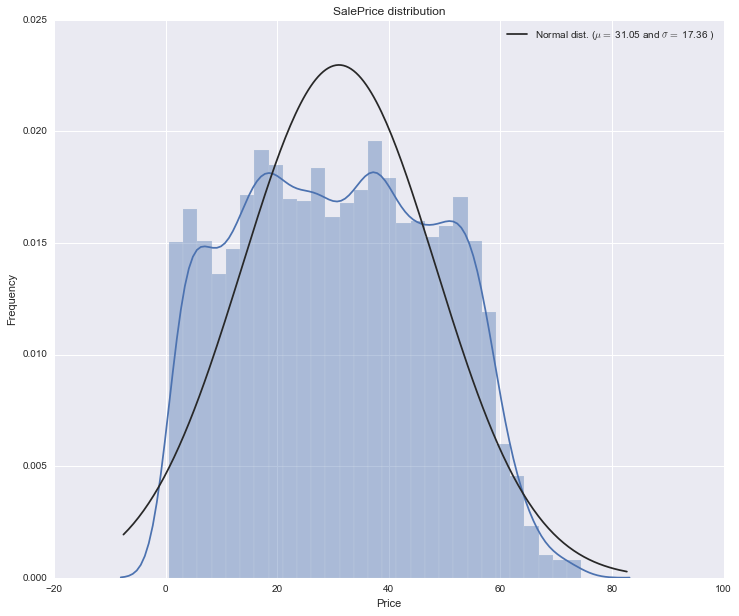

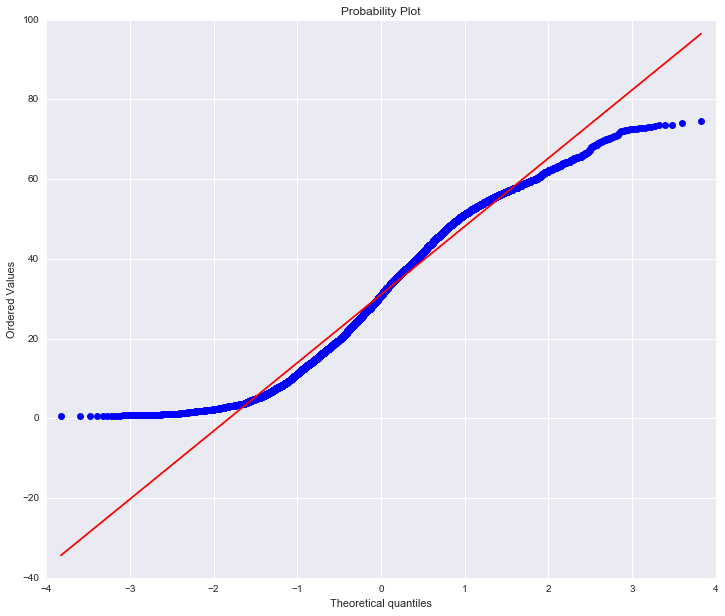

In [36]:
#Here, checking if the given sample is normally distributed or not. I have also used QQ-plot to check the skewness of the data.

sns.distplot(df_temp['Price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_temp['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_temp['Price'], plot=plt)
plt.show()

From the above plots, we can see that the given data is not exactly normally distributed. Therefore to check the significance we can use the non parametric method of One way Anova Kruskal-Wallis Test. Also, we would be checking for significant medians and not means.

__Now, we are to check for the following hypothesis:__ <br>
H<sub>0</sub> = There is no difference in median for each group <br>
H<sub>a</sub> = There is atleast one group that has significantly different median from others

In [37]:
safeway_prices = df_temp.loc[df_temp['Banner'] == 'Safeway']['Price']
Trader_Joes_prices = df_temp.loc[df_temp['Banner'] == 'Trader Joes']['Price']
Walmart_prices = df_temp.loc[df_temp['Banner'] == 'Walmart']['Price']
Wegmans_prices = df_temp.loc[df_temp['Banner'] == 'Wegmans']['Price']
Whole_Foods_prices = df_temp.loc[df_temp['Banner'] == 'Whole Foods']['Price']

In [38]:
model= stats.kruskal(safeway_prices,Trader_Joes_prices,Walmart_prices,Wegmans_prices, Whole_Foods_prices)

In [39]:
print("Kruskal-Wallis Statistic: ", model.statistic)
print("Kruskal-Wallis p-value: ", model.pvalue)

Kruskal-Wallis Statistic:  107.22189871432435
Kruskal-Wallis p-value:  2.846690493073999e-22


From the above results of Kruskal-Wallis Test we can infer that the p-value is significantly small. Therefore, we can say that there is atleast one group that has significantly different median from other. (i.e. __We reject the null hypothesis.__)

### Findings

1. From the above tables, we can see that the mean value increases when we exclude the data collected by Auditor ID: 713 for WholeFoods in Kansas state. Initially the mean value for WholeFoods was __\\$24.11__ but after excluding the data the mean price rises to __\\$34.80__, which is highest among all banners.


2. From the above tables, we can see that Walmart banner has the lowest mean value that is __\\$28.87__.


3. From the above graphs, we can see that Northern California has the highest mean price of __\\$35.43__.

### Conclusions

__Anomaly 1:__ The data shows that Auditor ID: 713 has entered \\$1.99 as the price for all the UPC's in Kansas WholeFoods which is an anamoly. So I recommend excluding this data.<br>



__Anomaly 2:__ Auditor ID: 98 from New York where as the data shows information from Norhtern California region which is an anomaly. So I recommend excluding this data.

### References

1. https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance